In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================
# 1. DADOS ANATEL
# ============================================

# Carregar dados
anatel = pd.read_csv('Estacoes_SMP.csv', encoding='utf-8', sep=';', low_memory=False)

# Filtrar 3G com faixas puras
anatel_3g_clean = anatel[
    (anatel['Geração'] == '3G') &
    (anatel['Tecnologia'] == 'WCDMA') &
    (anatel['Faixa Estação'].isin([850, 2100]))
].copy()

# Converter data
anatel_3g_clean['data_lic'] = pd.to_datetime(anatel_3g_clean['AnoMesLic'], format='%Y-%m')
anatel_3g_clean['ano'] = anatel_3g_clean['data_lic'].dt.year

# Aplicar filtros temporais por faixa
anatel_3g_clean = anatel_3g_clean[
    ((anatel_3g_clean['Faixa Estação'] == 2100) & (anatel_3g_clean['data_lic'] >= '1995-01-01')) |
    ((anatel_3g_clean['Faixa Estação'] == 850) & (anatel_3g_clean['data_lic'] >= '1995-01-01'))
]

# Filtrar até 2022 (última eleição com dados disponíveis)
anatel_3g_clean = anatel_3g_clean[anatel_3g_clean['data_lic'] <= '2022-12-31']

print(f"✅ Estações 3G LTE (faixas 850/2100, período correto): {len(anatel_3g_clean):,}")
print(f"✅ Municípios únicos: {anatel_3g_clean['Código IBGE'].nunique():,}")
print(f"✅ Período: {anatel_3g_clean['data_lic'].min()} a {anatel_3g_clean['data_lic'].max()}")

print("\n=== DISTRIBUIÇÃO POR FAIXA E ANO ===")
print("\nFaixa 2100 MHz:")
faixa_2100 = anatel_3g_clean[anatel_3g_clean['Faixa Estação'] == 2100]
print(faixa_2100['ano'].value_counts().sort_index())

print("\nFaixa 850 MHz:")
faixa_850 = anatel_3g_clean[anatel_3g_clean['Faixa Estação'] == 850]
print(faixa_850['ano'].value_counts().sort_index())


✅ Estações 3G LTE (faixas 850/2100, período correto): 217,912
✅ Municípios únicos: 5,524
✅ Período: 1999-01-01 00:00:00 a 2022-12-01 00:00:00

=== DISTRIBUIÇÃO POR FAIXA E ANO ===

Faixa 2100 MHz:
ano
1999    9177
2000    3524
2001    2603
2002    6759
2003    3836
2004    7446
2005    7044
2006    2513
2007    3369
2008    8253
2009    5133
2010    4975
2011    4066
2012    3632
2013    3000
2014    5631
2015    6979
2016    4951
2017    4550
2018    2592
2019    1221
2020     782
2021    5487
2022    4476
Name: count, dtype: int64

Faixa 850 MHz:
ano
1999    11062
2000     5018
2001     3295
2002     2878
2003     3920
2004     5518
2005     5540
2006     2756
2007     3490
2008     5147
2009     3170
2010     4387
2011     3830
2012     4215
2013     3369
2014     8116
2015     6332
2016     4110
2017     4373
2018     4327
2019     2341
2020     1829
2021     5212
2022     1678
Name: count, dtype: int64


In [14]:
# Criar dataset municipal
municipios_3g = anatel_3g_clean.groupby('Código IBGE').agg({
    'data_lic': 'min',
    'Código IBGE': 'count',
    'Município-UF': 'first',
    'UF': 'first',
    'Empresa Estação': 'first',
    'Faixa Estação': lambda x: x.iloc[0]  # Faixa da primeira estação
}).reset_index(drop=True)

municipios_3g.columns = ['primeira_estacao_3g', 'n_estacoes_3g_total', 
                          'Município-UF', 'UF', 'operadora_primeira', 
                          'faixa_primeira']

municipios_3g.insert(0, 'Código IBGE', 
                     anatel_3g_clean.groupby('Código IBGE')['Código IBGE'].first().values)

municipios_3g['ano_primeira_3g'] = municipios_3g['primeira_estacao_3g'].dt.year
municipios_3g['mes_primeira_3g'] = municipios_3g['primeira_estacao_3g'].dt.month
municipios_3g['trimestre_primeira_3g'] = municipios_3g['primeira_estacao_3g'].dt.quarter

municipios_3g = municipios_3g.sort_values('primeira_estacao_3g').reset_index(drop=True)

print(f"\n✅ Total de municípios com 3G: {len(municipios_3g):,}")
print(f"✅ Período: {municipios_3g['primeira_estacao_3g'].min()} a {municipios_3g['primeira_estacao_3g'].max()}")

print("\n=== MUNICÍPIOS POR ANO (PRIMEIRA ESTAÇÃO 3G) ===")
mun_por_ano = municipios_3g['ano_primeira_3g'].value_counts().sort_index()
print(mun_por_ano)



✅ Total de municípios com 3G: 5,524
✅ Período: 1999-01-01 00:00:00 a 2022-11-01 00:00:00

=== MUNICÍPIOS POR ANO (PRIMEIRA ESTAÇÃO 3G) ===
ano_primeira_3g
1999    1467
2000     322
2001     164
2002     156
2003      91
2004     269
2005     375
2006     185
2007     357
2008     421
2009     593
2010     337
2011      41
2012      37
2013      16
2014     173
2015     209
2016      42
2017      71
2018      74
2019      34
2020      15
2021      35
2022      40
Name: count, dtype: int64


In [15]:
# Estatísticas por ciclo eleitoral
print("\n=== ESTATÍSTICAS POR CICLO ELEITORAL ===")
ciclos = {
    'Antes Eleição 2014 (até Set/2014)': len(municipios_3g[municipios_3g['primeira_estacao_3g'] < '2014-10-01']),
    'Entre 2014 e 2016 (Out/2014 - Set/2016)': len(municipios_3g[(municipios_3g['primeira_estacao_3g'] >= '2014-10-01') & 
                                                                   (municipios_3g['primeira_estacao_3g'] < '2016-10-01')]),
    'Entre 2016 e 2018 (Out/2016 - Set/2018)': len(municipios_3g[(municipios_3g['primeira_estacao_3g'] >= '2016-10-01') & 
                                                                   (municipios_3g['primeira_estacao_3g'] < '2018-10-01')]),
    'Entre 2018 e 2022 (Out/2018 - Dez/2022)': len(municipios_3g[municipios_3g['primeira_estacao_3g'] >= '2018-10-01'])
}

for ciclo, n_mun in ciclos.items():
    pct = (n_mun / len(municipios_3g)) * 100
    print(f"{ciclo}: {n_mun:,} municípios ({pct:.1f}%)")

print("\n=== PRIMEIROS 20 MUNICÍPIOS COM 3G ===")
print(municipios_3g[['Município-UF', 'primeira_estacao_3g', 'faixa_primeira', 'operadora_primeira']].head(20))


=== ESTATÍSTICAS POR CICLO ELEITORAL ===
Antes Eleição 2014 (até Set/2014): 4,913 municípios (88.9%)
Entre 2014 e 2016 (Out/2014 - Set/2016): 329 municípios (6.0%)
Entre 2016 e 2018 (Out/2016 - Set/2018): 139 municípios (2.5%)
Entre 2018 e 2022 (Out/2018 - Dez/2022): 143 municípios (2.6%)

=== PRIMEIROS 20 MUNICÍPIOS COM 3G ===
                      Município-UF primeira_estacao_3g  faixa_primeira  \
0                    Itaboraí - RJ          1999-01-01             850   
1                  Petrópolis - RJ          1999-01-01            2100   
2                      Osasco - SP          1999-01-01             850   
3              Nova Xavantina - MT          1999-01-01            2100   
4                    Salvador - BA          1999-01-01            2100   
5               Capitão Enéas - MG          1999-01-01             850   
6               Rosário Oeste - MT          1999-01-01             850   
7   Santo Antônio do Leverger - MT          1999-01-01             850   
8  

✅ Gráfico salvo: analise_3g_limpa_final.png


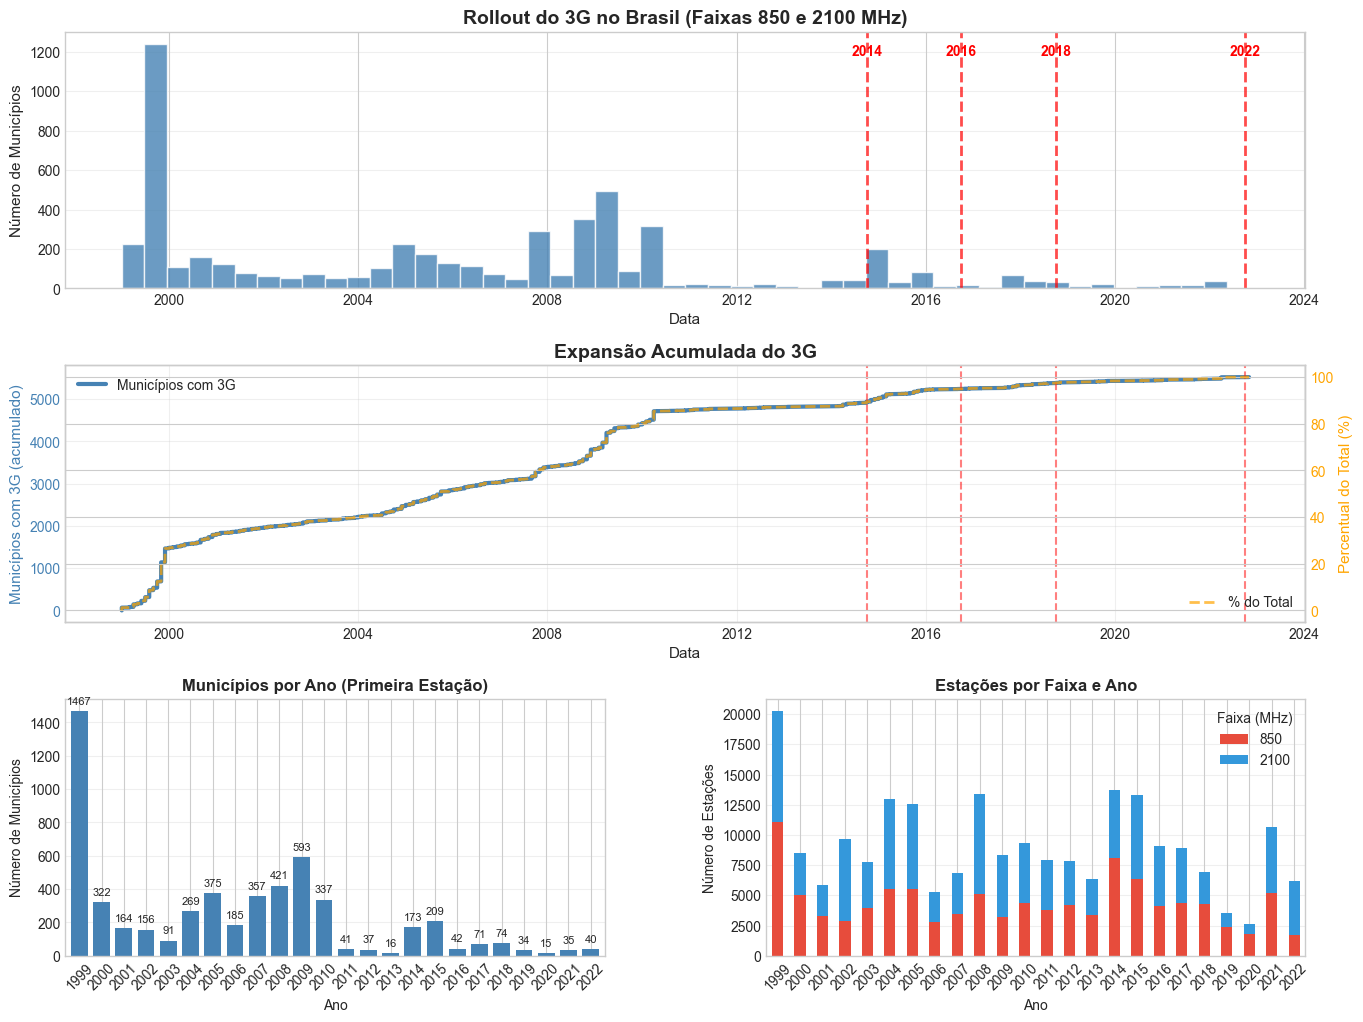

In [16]:
# Visualizações 3G

# Configurar estilo
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Figura com 4 subplots
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Subplot 1: Histograma temporal
ax1 = fig.add_subplot(gs[0, :])
municipios_3g['primeira_estacao_3g'].hist(bins=50, ax=ax1, color='steelblue', edgecolor='white', alpha=0.8)
for ano, label in [(2014, '2014'), (2016, '2016'), (2018, '2018'), (2022, '2022')]:
    ax1.axvline(pd.Timestamp(f'{ano}-10-01'), color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax1.text(pd.Timestamp(f'{ano}-10-01'), ax1.get_ylim()[1]*0.95, label, 
             ha='center', va='top', fontsize=10, fontweight='bold', color='red')
ax1.set_title('Rollout do 3G no Brasil (Faixas 850 e 2100 MHz)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Data', fontsize=11)
ax1.set_ylabel('Número de Municípios', fontsize=11)
ax1.grid(axis='y', alpha=0.3)

# Subplot 2: Acumulado
ax2 = fig.add_subplot(gs[1, :])
municipios_sorted_3G = municipios_3g.sort_values('primeira_estacao_3g').copy()
municipios_sorted_3G['acumulado'] = range(1, len(municipios_sorted_3G) + 1)
municipios_sorted_3G['pct_acumulado'] = (municipios_sorted_3G['acumulado'] / len(municipios_sorted_3G)) * 100

ax2.plot(municipios_sorted_3G['primeira_estacao_3g'], municipios_sorted_3G['acumulado'], 
         linewidth=3, color='steelblue', label='Municípios com 3G')
ax2_twin = ax2.twinx()
ax2_twin.plot(municipios_sorted_3G['primeira_estacao_3g'], municipios_sorted_3G['pct_acumulado'], 
              linewidth=2, color='orange', linestyle='--', alpha=0.7, label='% do Total')

for ano in [2014, 2016, 2018, 2022]:
    ax2.axvline(pd.Timestamp(f'{ano}-10-01'), color='red', linestyle='--', linewidth=1.5, alpha=0.5)

ax2.set_title('Expansão Acumulada do 3G', fontsize=14, fontweight='bold')
ax2.set_xlabel('Data', fontsize=11)
ax2.set_ylabel('Municípios com 3G (acumulado)', fontsize=11, color='steelblue')
ax2_twin.set_ylabel('Percentual do Total (%)', fontsize=11, color='orange')
ax2.tick_params(axis='y', labelcolor='steelblue')
ax2_twin.tick_params(axis='y', labelcolor='orange')
ax2.grid(alpha=0.3)
ax2.legend(loc='upper left')
ax2_twin.legend(loc='lower right')

# Subplot 3: Por ano (barras)
ax3 = fig.add_subplot(gs[2, 0])
mun_por_ano.plot(kind='bar', ax=ax3, color='steelblue', width=0.75)
ax3.set_title('Municípios por Ano (Primeira Estação)', fontsize=12, fontweight='bold')
ax3.set_xlabel('Ano', fontsize=10)
ax3.set_ylabel('Número de Municípios', fontsize=10)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)
for i, v in enumerate(mun_por_ano.values):
    if v > 0:
        ax3.text(i, v + max(mun_por_ano)*0.02, str(v), ha='center', va='bottom', fontsize=8)
ax3.grid(axis='y', alpha=0.3)

# Subplot 4: Por faixa ao longo do tempo
ax4 = fig.add_subplot(gs[2, 1])
faixa_ano = anatel_3g_clean.groupby(['ano', 'Faixa Estação']).size().unstack(fill_value=0)
faixa_ano.plot(kind='bar', stacked=True, ax=ax4, color=['#e74c3c', '#3498db'])
ax4.set_title('Estações por Faixa e Ano', fontsize=12, fontweight='bold')
ax4.set_xlabel('Ano', fontsize=10)
ax4.set_ylabel('Número de Estações', fontsize=10)
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=45)
ax4.legend(title='Faixa (MHz)', labels=['850', '2100'])
ax4.grid(axis='y', alpha=0.3)

plt.savefig('analise_3g_limpa_final.png', dpi=300, bbox_inches='tight')
print("✅ Gráfico salvo: analise_3g_limpa_final.png")
plt.show()

In [17]:
# Salvar dados 3G
municipios_3g.to_csv('municipios_3g_limpo_final.csv', index=False, encoding='utf-8-sig')
print("✅ Arquivo salvo: municipios_3g_limpo_final.csv")

# Estatísticas detalhadas
with open('resumo_3g_limpo_final.txt', 'w', encoding='utf-8') as f:
    f.write("ANÁLISE DO ROLLOUT DO 3G NO BRASIL (DADOS LIMPOS)\n")
    f.write("Critério: Faixas 850 e 2100 MHz nos períodos corretos\n")
    
    f.write(f"Total de estações 3G WCMDA: {len(anatel_3g_clean):,}\n")
    f.write(f"Total de municípios com 3G: {len(municipios_3g):,}\n")
    f.write(f"Período: {municipios_3g['primeira_estacao_3g'].min()} a {municipios_3g['primeira_estacao_3g'].max()}\n\n")
    
    f.write("Municípios por ano (primeira estação 3G):\n")
    for ano, count in mun_por_ano.items():
        f.write(f"  {int(ano)}: {count:>4,} municípios\n")

    f.write("DISTRIBUIÇÃO POR CICLO ELEITORAL\n")
    for ciclo, n_mun in ciclos.items():
        pct = (n_mun / len(municipios_3g)) * 100
        f.write(f"{ciclo}:\n")
        f.write(f"  {n_mun:,} municípios ({pct:.1f}% do total)\n\n")

print("✅ Arquivo salvo: resumo_3g_limpo_final.txt")
print("✅ ANÁLISE COMPLETA COM DADOS LIMPOS!")
print("\nArquivos gerados:")
print("  1. municipios_3g_limpo_final.csv")
print("  2. resumo_3g_limpo_final.txt")
print("  3. analise_3g_limpa_final.png")

✅ Arquivo salvo: municipios_3g_limpo_final.csv
✅ Arquivo salvo: resumo_3g_limpo_final.txt
✅ ANÁLISE COMPLETA COM DADOS LIMPOS!

Arquivos gerados:
  1. municipios_3g_limpo_final.csv
  2. resumo_3g_limpo_final.txt
  3. analise_3g_limpa_final.png


In [18]:
# ============================================
# 2. CARREGAR TABELA DE CORRESPONDÊNCIA TSE
# ============================================

# Ajuste o nome do arquivo conforme necessário
correspondencia_tse = pd.read_csv(
    'depara-ibge-tse.csv',  # ou o nome que você deu ao arquivo
    encoding='latin1',  # ou 'utf-8' se necessário
    sep=';'  # ajuste o delimitador se necessário
)

print(f"✅ Tabela TSE carregada: {len(correspondencia_tse)} registros")

# Ver estrutura
print("\nColunas disponíveis:")
print(correspondencia_tse.columns.tolist())

print("\nPrimeiras linhas:")
print(correspondencia_tse.head())

# Limpar e padronizar
correspondencia_tse = correspondencia_tse.rename(columns={
    'CD_MUNICIPIO_TSE': 'codigo_tse',
    'CD_MUNICIPIO_IBGE': 'codigo_ibge',
    'NM_MUNICIPIO_TSE': 'municipio_tse',
    'NM_MUNICIPIO_IBGE': 'municipio_ibge',
    'SG_UF': 'uf',
    'NM_UF': 'nome_uf'
})
# Selecionar colunas relevantes
correspondencia_tse = correspondencia_tse[[
    'codigo_tse', 'codigo_ibge', 'municipio_tse', 'municipio_ibge', 'uf', 'nome_uf'
]].copy()

# Garantir tipos corretos
correspondencia_tse['codigo_tse'] = correspondencia_tse['codigo_tse'].astype(int)
correspondencia_tse['codigo_ibge'] = correspondencia_tse['codigo_ibge'].astype(int)

# Verificar duplicatas
print(f"\n=== VERIFICAÇÕES ===")
print(f"Códigos TSE únicos: {correspondencia_tse['codigo_tse'].nunique()}")
print(f"Códigos IBGE únicos: {correspondencia_tse['codigo_ibge'].nunique()}")

duplicados_tse = correspondencia_tse['codigo_tse'].duplicated().sum()
duplicados_ibge = correspondencia_tse['codigo_ibge'].duplicated().sum()

print(f"Códigos TSE duplicados: {duplicados_tse}")
print(f"Códigos IBGE duplicados: {duplicados_ibge}")

if duplicados_tse > 0 or duplicados_ibge > 0:
    print("⚠️ ATENÇÃO: Há duplicatas! Removendo...")
    correspondencia_tse = correspondencia_tse.drop_duplicates(subset=['codigo_ibge'], keep='first')
    print(f"Após remoção: {len(correspondencia_tse)} registros")

✅ Tabela TSE carregada: 5571 registros

Colunas disponíveis:
['DT_GERACAO', 'HH_GERACAO', 'CD_UF_TSE', 'CD_UF_IBGE', 'SG_UF', 'NM_UF', 'CD_MUNICIPIO_TSE', 'NM_MUNICIPIO_TSE', 'CD_MUNICIPIO_IBGE', 'NM_MUNICIPIO_IBGE']

Primeiras linhas:
   DT_GERACAO HH_GERACAO  CD_UF_TSE  CD_UF_IBGE SG_UF NM_UF  CD_MUNICIPIO_TSE  \
0  19/10/2025   09:00:07         24          12    AC  Acre              1007   
1  19/10/2025   09:00:07         24          12    AC  Acre              1015   
2  19/10/2025   09:00:07         24          12    AC  Acre              1023   
3  19/10/2025   09:00:07         24          12    AC  Acre              1031   
4  19/10/2025   09:00:07         24          12    AC  Acre              1040   

       NM_MUNICIPIO_TSE  CD_MUNICIPIO_IBGE     NM_MUNICIPIO_IBGE  
0                Bujari            1200138                Bujari  
1              Capixaba            1200179              Capixaba  
2            Porto Acre            1200807            Porto Acre  
3   Santa

In [19]:
# ============================================
# 3. MERGER DADOS ANATEL - TSE
# ============================================

# Carregar dados 4G
municipios_3g = pd.read_csv('municipios_3g_limpo_final.csv')

print(f"Municípios com 3G: {len(municipios_3g)}")
print(f"Códigos IBGE únicos: {municipios_3g['Código IBGE'].nunique()}")

#Fazer merge
municipios_3g_tse = municipios_3g.merge(
    correspondencia_tse,
    left_on='Código IBGE',
    right_on='codigo_ibge',
    how='left',
    indicator=True
)

# Resultados do merge
print("\nResultados do merge:")
merge_stats = municipios_3g_tse['_merge'].value_counts()
print(merge_stats)

# Calcular taxa de match
matched = len(municipios_3g_tse[municipios_3g_tse['_merge'] == 'both'])
taxa_match = (matched / len(municipios_3g)) * 100
print(f"\n✅ Taxa de match: {taxa_match:.2f}%")

# Identificar municípios sem match
sem_match = municipios_3g_tse[municipios_3g_tse['_merge'] == 'left_only']

if len(sem_match) > 0:
    print(f"\n⚠️ {len(sem_match)} municípios SEM correspondência TSE ({100-taxa_match:.2f}%)")
    print("\nPrimeiros 20 sem match:")
    print(sem_match[['Código IBGE', 'Município-UF', 'UF', 'primeira_estacao_4g']].head(20))
    
    # Salvar lista completa
    sem_match[['Código IBGE', 'Município-UF', 'UF']].to_csv(
        'municipios_sem_correspondencia_tse.csv', 
        index=False,
        encoding='utf-8-sig'
    )
    print("Lista completa salva: municipios_sem_correspondencia_tse.csv")
    
    # Análise dos sem match
    print("\nDistribuição por UF dos municípios sem match:")
    print(sem_match['UF'].value_counts())
else:
    print("\n🎉 PERFEITO! 100% dos municípios têm correspondência TSE!")

# Manter apenas municípios com match
municipios_3g_tse = municipios_3g_tse[municipios_3g_tse['_merge'] == 'both'].copy()
municipios_3g_tse = municipios_3g_tse.drop(columns=['_merge'])

Municípios com 3G: 5524
Códigos IBGE únicos: 5524

Resultados do merge:
_merge
both          5524
left_only        0
right_only       0
Name: count, dtype: int64

✅ Taxa de match: 100.00%

🎉 PERFEITO! 100% dos municípios têm correspondência TSE!


In [20]:
# ============================================
# 4. CRIAR VARIÁVEIS DE TRATAMENTO
# ============================================

# Converter data para datetime se necessário
municipios_3g_tse['primeira_estacao_3g'] = pd.to_datetime(
    municipios_3g_tse['primeira_estacao_3g']
)

# Variáveis de tratamento por ano eleitoral
eleicoes = [2010, 2014, 2018, 2022]

for ano in eleicoes:
    # Dummy: tem 3G antes da eleição?
    data_eleicao = pd.Timestamp(f'{ano}-10-01')
    municipios_3g_tse[f'tem_3g_{ano}'] = (
        municipios_3g_tse['primeira_estacao_3g'] < data_eleicao
    ).astype(int)
    
    # Dose-response: há quantos anos tem 3G?
    municipios_3g_tse[f'anos_com_3g_{ano}'] = np.where(
        municipios_3g_tse[f'tem_3g_{ano}'] == 1,
        (data_eleicao - municipios_3g_tse['primeira_estacao_3g']).dt.days / 365.25,
        0
    )

# Mostrar distribuição
print("\nDistribuição de municípios com 3G por ano eleitoral:")
print("-" * 60)
for ano in eleicoes:
    n_tratados = municipios_3g_tse[f'tem_3g_{ano}'].sum()
    n_controle = len(municipios_3g_tse) - n_tratados
    pct_tratados = (n_tratados / len(municipios_3g_tse)) * 100
    
    print(f"{ano}:")
    print(f"  Com 3G (tratados): {n_tratados:>4,} ({pct_tratados:>5.1f}%)")
    print(f"  Sem 3G (controle): {n_controle:>4,} ({100-pct_tratados:>5.1f}%)")

# Estatísticas de anos com 3G (dose-response)
print("\n=== DOSE-RESPONSE: Anos com 3G ===")
for ano in [2014, 2018, 2022]:
    tratados = municipios_3g_tse[municipios_3g_tse[f'tem_3g_{ano}'] == 1]
    if len(tratados) > 0:
        media_anos = tratados[f'anos_com_3g_{ano}'].mean()
        max_anos = tratados[f'anos_com_3g_{ano}'].max()
        print(f"{ano}: média = {media_anos:.1f} anos, máximo = {max_anos:.1f} anos")



Distribuição de municípios com 3G por ano eleitoral:
------------------------------------------------------------
2010:
  Com 3G (tratados): 4,724 ( 85.5%)
  Sem 3G (controle):  800 ( 14.5%)
2014:
  Com 3G (tratados): 4,913 ( 88.9%)
  Sem 3G (controle):  611 ( 11.1%)
2018:
  Com 3G (tratados): 5,381 ( 97.4%)
  Sem 3G (controle):  143 (  2.6%)
2022:
  Com 3G (tratados): 5,521 ( 99.9%)
  Sem 3G (controle):    3 (  0.1%)

=== DOSE-RESPONSE: Anos com 3G ===
2014: média = 10.1 anos, máximo = 15.7 anos
2018: média = 13.1 anos, máximo = 19.7 anos
2022: média = 16.7 anos, máximo = 23.7 anos


In [21]:
# ============================================
# 5. ORGANIZAR E SALVAR DATASET FINAL
# ============================================

print("\n=== PREPARANDO DATASET FINAL ===")

# Selecionar e ordenar colunas
colunas_finais = [
    # Identificadores
    'codigo_tse', 'codigo_ibge', 'municipio_tse', 'uf', 'nome_uf',
    'Município-UF',  # Nome original da Anatel (para conferência)
    
    # Informações do 3G
    'primeira_estacao_3g', 'ano_primeira_3g', 'mes_primeira_3g',
    'n_estacoes_3g_total', 'operadora_primeira', 'faixa_primeira',
    
    # Variáveis de tratamento (dummies)
    'tem_3g_2010', 'tem_3g_2014', 'tem_3g_2018', 'tem_3g_2022',
    
    # Variáveis de dose-response
    'anos_com_3g_2014', 'anos_com_3g_2018', 'anos_com_3g_2022'
]

municipios_3g_tse_final = municipios_3g_tse[colunas_finais].copy()

# Ordenar por código TSE
municipios_3g_tse_final = municipios_3g_tse_final.sort_values('codigo_tse').reset_index(drop=True)

# Salvar
arquivo_saida = 'municipios_3g_com_codigo_tse.csv'
municipios_3g_tse_final.to_csv(arquivo_saida, index=False, encoding='utf-8-sig')

print(f"✅ Dataset final salvo: {arquivo_saida}")

# Estatísticas descritivas e visualização

print("\n" + "="*70)
print("RESUMO FINAL DO DATASET")
print("="*70)

print(f"\nTotal de municípios no dataset: {len(municipios_3g_tse_final):,}")
print(f"Taxa de match IBGE→TSE: {taxa_match:.2f}%")
print(f"Período de dados: {municipios_3g_tse_final['primeira_estacao_3g'].min().date()} a {municipios_3g_tse_final['primeira_estacao_3g'].max().date()}")

print("\n=== DISTRIBUIÇÃO GEOGRÁFICA ===")
print(municipios_3g_tse_final['uf'].value_counts().head(10))

print("\n=== PRIMEIRAS 10 LINHAS DO DATASET FINAL ===")
print(municipios_3g_tse_final.head(10).to_string())

print("\n=== PRIMEIRAS 10 LINHAS DO DATASET FINAL ===")
print(municipios_3g_tse_final.head(10))

# Verificação final de integridade
print("\n=== VERIFICAÇÕES DE INTEGRIDADE ===")
print(f"Códigos TSE únicos: {municipios_3g_tse_final['codigo_tse'].nunique()}")
print(f"Códigos TSE duplicados: {municipios_3g_tse_final['codigo_tse'].duplicated().sum()}")
print(f"Valores missing em codigo_tse: {municipios_3g_tse_final['codigo_tse'].isna().sum()}")
print(f"Valores missing em primeira_estacao_3g: {municipios_3g_tse_final['primeira_estacao_3g'].isna().sum()}")

# Estatísticas por faixa
print("\n=== DISTRIBUIÇÃO POR FAIXA DE FREQUÊNCIA ===")
print(municipios_3g_tse_final['faixa_primeira'].value_counts())


=== PREPARANDO DATASET FINAL ===
✅ Dataset final salvo: municipios_3g_com_codigo_tse.csv

RESUMO FINAL DO DATASET

Total de municípios no dataset: 5,524
Taxa de match IBGE→TSE: 100.00%
Período de dados: 1999-01-01 a 2022-11-01

=== DISTRIBUIÇÃO GEOGRÁFICA ===
uf
MG    850
SP    645
RS    482
BA    417
PR    398
SC    295
GO    238
PB    222
PI    219
MA    216
Name: count, dtype: int64

=== PRIMEIRAS 10 LINHAS DO DATASET FINAL ===
   codigo_tse  codigo_ibge        municipio_tse  uf   nome_uf              Município-UF primeira_estacao_3g  ano_primeira_3g  mes_primeira_3g  n_estacoes_3g_total operadora_primeira  faixa_primeira  tem_3g_2010  tem_3g_2014  tem_3g_2018  tem_3g_2022  anos_com_3g_2014  anos_com_3g_2018  anos_com_3g_2022
0          19      1100106        Guajará-Mirim  RO  Rondônia        Guajará-Mirim - RO          1999-11-01             1999               11                   10              CLARO             850            1            1            1            1         14

In [22]:
# ============================================
# DIAGNÓSTICO: ONDE PERDEMOS MUNICÍPIOS?
# ============================================

print(f"Municípios após merge TSE: {len(municipios_3g_tse)}")
print(f"Municípios no dataset final: {len(municipios_3g_tse_final)}")
print(f"PERDA: {len(municipios_3g_tse) - len(municipios_3g_tse_final)}")

# Verificar NaNs em cada coluna
print("\n🔍 VALORES MISSING POR COLUNA:")
for col in colunas_finais:
    n_missing = municipios_3g_tse[col].isna().sum()
    if n_missing > 0:
        print(f"  {col}: {n_missing} missing ({n_missing/len(municipios_3g_tse)*100:.1f}%)")

# Identificar quais municípios foram perdidos
municipios_iniciais = set(municipios_3g_tse['codigo_tse'])
municipios_finais = set(municipios_3g_tse_final['codigo_tse'])
municipios_perdidos_ids = municipios_iniciais - municipios_finais

if len(municipios_perdidos_ids) > 0:
    print(f"\n🚨 PERDIDOS: {len(municipios_perdidos_ids)} municípios")
    
    # Ver quais são
    perdidos = municipios_3g_tse[municipios_3g_tse['codigo_tse'].isin(municipios_perdidos_ids)]
    print("\n=== MUNICÍPIOS PERDIDOS ===")
    print(perdidos[['codigo_tse', 'Município-UF', 'primeira_estacao_3g', 'ano_primeira_3g']].head(20))
    
    # Ver distribuição temporal
    print("\n=== DISTRIBUIÇÃO TEMPORAL DOS PERDIDOS ===")
    print(perdidos['ano_primeira_3g'].value_counts().sort_index())

Municípios após merge TSE: 5524
Municípios no dataset final: 5524
PERDA: 0

🔍 VALORES MISSING POR COLUNA:
